## Conditional Generative Adversarial Network (CGAN)

Paper:
- [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784)

Helpful Resources:
- [Aladdin Persson's playlist on GANs](https://youtube.com/playlist?list=PLhhyoLH6IjfwIp8bZnzX8QR30TRcHO8Va&si=8ooImkbbXhCUC1xB)
- [GANs specialization on Coursera](https://www.coursera.org/specializations/generative-adversarial-networks-gans)  $\; \rightarrow \;$ most of the content of this notebook has been borrowed from this course
- [Stanford's Deep Generative Models playlist](https://youtube.com/playlist?list=PLoROMvodv4rPOWA-omMM6STXaWW4FvJT8&si=N_TpTe1bPIhte-t8)

This notebook just includes the implementation of the CGAN model and its training loop. The results are not shown here.

Feel free to check the results on my Kaggle notebook: https://www.kaggle.com/code/aryamanbansal/conditional_gan

#### Imports and some helpful utility functions

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from datetime import datetime
import pytz
import time
import os
from tqdm import tqdm
import random
import gc

%matplotlib inline

print("Imports done!")

Imports done!


In [34]:
def get_torch_version():
    """
    Returns the version of PyTorch installed.
    """
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed: int = 42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        if get_torch_version() <= 1.7:
            torch.set_deterministic(True)
        else:
            torch.use_deterministic_algorithms(True)


def set_scheduler(scheduler, results, scheduler_on):
    """
    Makes the neccessary updates to the scheduler.
    
    Parameters:
    - scheduler: torch.optim.lr_scheduler, the scheduler to update.
    - results: dict, the results dictionary containing the training and test metric values.
        Keys in the results dictionary are: "gen_train_loss", "gen_val_loss", 
                                            "disc_train_loss", "disc_val_loss".
    - scheduler_on: str, the metric to use for the scheduler update.
    """
    if scheduler_on == "gen_val_loss":
        scheduler.step(results["gen_val_loss"][-1])
    if scheduler_on == "disc_val_loss":
        scheduler.step(results["disc_val_loss"][-1])
    elif scheduler_on == "gen_train_loss":
        scheduler.step(results["gen_train_loss"][-1])
    elif scheduler_on == "disc_train_loss":
        scheduler.step(results["disc_train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def save_model_info(path: str, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    """
    Saves the model and optimizer weights to the specified path.

    Parameters:
    - path: str, the path to the directory to save the model and optimizer weights.
    - model: nn.Module, the model to save.
    - model_name: str, the name of the model weights file.
    - optimizer: torch.optim, the optimizer to save.
    - optimizer_name: str, the name of the optimizer weights file.
    - scheduler: torch.optim.lr_scheduler, the scheduler to save.
    - scheduler_name: str, the name of the scheduler weights file.

    Free advice:
    A good practice is to transfer the model to the CPU before calling torch.save as this 
    will save tensors as CPU tensors and not as CUDA tensors. This will help in loading
    the model onto any machine, whether it contains CUDA capabilities or not.
    """
    model.to("cpu")
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(path, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    """
    Loads the model and optimizer weights from the specified path.

    Parameters:
    - path: str, the path to the directory containing the model and optimizer weights.
    - device: str, the device to load the model and optimizer weights onto.
    - model: nn.Module, the model to load the weights into.
    - model_name: str, the name of the model weights file.
    - optimizer: torch.optim, the optimizer to load the weights into.
    - optimizer_name: str, the name of the optimizer weights file.
    - scheduler: torch.optim.lr_scheduler, the scheduler to load the weights into.
    - scheduler_name: str, the name of the scheduler weights file.
    """
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


def show_tensor_images(image_tensor, num_images=25, size=(1,28,28)):
    """
    Function for visualizing images: Given a tensor of images, 
    number of images, and size per image, plots and prints the 
    images in an uniform grid.
    """
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


def visualize_results(results):
    """
    Plots the train and test losses of the generator and the discriminator.

    results is dictionary with keys: 
        "gen_train_loss", "gen_val_loss", "disc_train_loss", "disc_val_loss".
    """
    gen_train_loss = results["gen_train_loss"]
    gen_val_loss = results["gen_val_loss"]
    disc_train_loss = results["disc_train_loss"]
    disc_val_loss = results["disc_val_loss"]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Training Loss")
    ax[0].plot(gen_train_loss, label="generator", color="orange")
    ax[0].plot(disc_train_loss, label="discriminator", color="blue")
    ax[0].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Validation Loss")
    ax[1].plot(gen_val_loss, label="generator", color="orange")
    ax[1].plot(disc_val_loss, label="discriminator", color="blue")
    ax[1].legend()
    plt.show()


print("Utility functions created!")

Utility functions created!


## Some theory about CGANs

Before we jump in to the code, let's understand the theory behind CGANs, and why we need them. 

Note: the following notes are heavily inspired from the [GANs specialization on Coursera](https://www.coursera.org/specializations/generative-adversarial-networks-gans).


#### **Motivation**

Let's first understand the difference between unconditional and conditional generation.

Up till now, the models we built (simple GAN, DCGAN, and WGAN) were all unconditional GANs. This means that we input some random noise vector into the generator, and it generates a random image. So, we don't have any control over what our GAN is generating. In addition, we don't need the dataset to be labelled, as an unconditional GAN just needs the datapoints and not their corresponding labels.

On the other hand, in conditional generation, we can control what our GAN generates. We can input some information to the generator, and it will generate an image based on that information. For example, we can input a label to the generator, and it will generate an image of that label. However, the generator can generator any variation of that label, and not just the exact same image of what you have in mind. Consider this analogy: we go to a vending machine and insert some money along with the itemcode of the item we want. The vending machine will give us the item corresponding to that itemcode, but we can't choose all the features (say, expiration date or manufacturing date) of that item. So, when using a conditional GAN, we input the label of the class we want, and the generator generates some example of that class. In addition, the dataset needs to be labelled, as we need to input the label to the generator.

### **How to make a GAN conditional?**

#### **The input to the generator of a CGAN.**

We've already seen with unconditional generation that the generator needs a noise vector to produce random examples. For conditional generation, we also need a vector to tell the generator from which class the generated examples should come from. This new vector is called a class vector, which is usually a one-hot vector, which means that there are zeros in every position except for one position corresponding to the class we want. The input to the generator in a conditional GAN is actually a concatenated vector of both the noise vector and the class vector. Here, the class vector tells the generator which class to generate and the noise vector tells it what variation of that class to generate. Of course, since the noise vector is random, so we cannot control the exact variation of the class that the generator generates. If we use a different noise vector every time but the same class vector, the generator will generate different variations of the same class. 

!["cgan_gen_input"](./imgs/cgan_gen_input.png "cgan_gen_input")

Source: [Course 1 Week 4 of GANs specialization on Coursera](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans?specialization=generative-adversarial-networks-gans)

<br>

#### **The input to the discriminator of a CGAN.**

In the case of unconditional GANs, the input to the discriminator was just the image. To make the GAN conditional, we need some way of conveying the class information to discriminator. We saw above that the input to the generator was a concatenated vector of the noise vector and the class vector, where the class vector was a one-hot vector. Since we're feeding the discriminator an image (which can either be RGB or grayscale) and not just a noise vector, so we'll need to adjust the class vector to be the same size as the image. We can do this by conveying class information in the form of additional channels, where all the newly added channels are matrices filled with zeros except for one channel corresponding to the class we want that is filled with ones. We can see how this can be done as in the below diagram.

!["cgan_disc_input"](./imgs/cgan_disc_input.png "cgan_disc_input")

Source: [Course 1 Week 4 of GANs specialization on Coursera](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans?specialization=generative-adversarial-networks-gans)

There are many other less space consuming ways of conveying class information to the discriminator, like compressing the class information in another format. We can even create a separate neural network head to do that for us, which would be wise if we had many different classes. However, when the number of classes is around 10 or so, then it's alright to just use the above described method.

<br>

#### **How does the generator learn to generate the correct class?**

The discriminator receives both the image and its corresponding class label and will classify the images based on if they look like real images from that specific class or not. For example, consider that we're building a CGAN to generate different species of dogs. Now, if the generator is asked to generate an image of a golden retriever, but if it generates an image of a poodle (no matter how realistic-looking that image might be), then the discriminator will give a very low probability of the generated image being real as it's not a golden retriever. So, the generator will learn to generate images that belong to whatever class is input to it, and not just any random image.

## Alright enough theory, let's write some code now!

#### Loading the data

In [35]:
class SomeDataClass:
    def __init__(self, batch_size=128):
        self.batch_size = batch_size
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])
        self.train_dataset = MNIST(root="dataset/", 
                              transform=self.transformations, 
                              download=True, train=True)
        self.valid_dataset = MNIST(root="dataset/", 
                                  transform=self.transformations, 
                                  download=True, train=False)

    def get_trainloader(self):
        """Returns the training dataloader."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, 
                          shuffle=True)

    def get_validloader(self):
        """Returns the validation dataloader."""
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, 
                          shuffle=False)
    

In [ ]:
def fn():
    data = SomeDataClass()
    train_loader = data.get_trainloader()
    for item in train_loader:
        print(len(item))
        print(item[0].shape, item[1].shape)
        break

fn()

2
torch.Size([128, 1, 28, 28]) torch.Size([128])


There are no major changes in the architectures of the generator and the discriminator of CGAN as compared to that of DCGAN. The only change is that we now also pass the class information to both the models. This means that:
- the generator now takes in both the noise vector and the class vector as input.
- the discriminator now takes in the image along with the class matrices as input.

#### Model Architectures and Hyperparameters

In [36]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, img_channel=1, hidden_dim=64):
        """
        The Generator class.

        Parameters:
            - input_dim: the dimension of the input vector, a scalar
            - img_channel: the number of channels of the output image, a scalar
                (MNIST is grayscale, so default value is img_channel=1)
            - hidden_dim: the inner dimension, a scalar
        """
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.gen = nn.Sequential(
            self.gen_block(input_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True)
        )

    def gen_block(self, in_channel, out_channel, kernel_size=3, stride=2, 
                  final_layer=False):
        """
        Returns the layers of a generator block.

        Parameters:
        - in_channel: the number of channels in the input, a scalar
        - out_channel: the number of channels in the output, a scalar
        - kernel_size: the size of the kernel, a scalar
        - stride: the stride of the kernel, a scalar
        - final_layer: a boolean, True if this is the final layer and False otherwise
        """
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, 
                                   kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(out_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channel, out_channel, 
                                   kernel_size=kernel_size, stride=stride),
                nn.Tanh()
            )
    
    def forward(self, noise):
        """
        Given a noise tensor, returns the generated image.
        """
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


In [37]:
class Discriminator(nn.Module):
    def __init__(self, img_channel=1, hidden_dim=16):
        """
        Parameters:
        - img_channel: the number of channels of the input image, a scalar
            (MNIST is grayscale, so default value is img_channel=1)
        - hidden_dim: the inner dimension, a scalar
        """
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim),
            self.disc_block(hidden_dim, hidden_dim*2),
            self.disc_block(hidden_dim*2, 1, final_layer=True)
        )

    def disc_block(self, in_channel, out_channel, kernel_size=4, stride=2,
                   final_layer=False):
          """
          Returns the layers of a discriminator block.
    
          Parameters:
          - in_channel: the number of channels in the input, a scalar
          - out_channel: the number of channels in the output, a scalar
          - kernel_size: the size of the kernel, a scalar
          - stride: the stride of the kernel, a scalar
          - final_layer: a boolean, True if this is the final layer and False otherwise
          """
          if not final_layer:
                return nn.Sequential(
                 nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, 
                           stride=stride),
                 nn.BatchNorm2d(out_channel),
                 nn.LeakyReLU(0.2, inplace=True)
                )
          else:
                return nn.Sequential(
                 nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, 
                           stride=stride),
                )

    def forward(self, image):
        """
        Given an image tensor, returns a 1-dimension tensor 
        representing fake/real.
        Parameters:
            image: a flattened image tensor
        """
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


#### Class information

Now, we need a way to pass class information to the generator. We do this by creating a class vector, which is a one-hot vector, where the length of the vector is the number of classes and each index represents a class. The vector is filled with zeroes except at one index, which corresponds to the class label, where we put a 1. For example, if we have 10 classes, then the class vector for the class label 2 (note: class labels start from 0 till n-1, where n is the number of classes) would be `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]`.

In [38]:
# the first arugment is tensor containing the different class labels
# the second argument is the number of classes
F.one_hot(torch.tensor([0,1,2,3,4,5,6,7,8,9]), num_classes=10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

Okay, so now that we have figured out how to create a class vector, let's now concatenate the class vector with the noise vector to create the input vector that we finally send to the generator. In addition, we must that both the noise vector and the class vector are of the same type, ie, float.

In [39]:
def combine_vectors(x, y):
    """
    Function for combining two vectors with shapes (n_samples, ?) 
    and (n_samples, ?).
    Note: ? as the second dimension simply means that we do not 
    need to know the 2nd dimension of the 2 vectors x and y.  
    Parameters:
      x: (n_samples, ?) the first vector. This should typically be
      the noise vector with the shape (n_samples, z_dim).
      y: (n_samples, ?) the second vector. This should typically be
      the class vector with the shape (n_samples, n_classes).
    """
    # when concatenating x and y vectors, we need to ensure that 
    # both of them are floats, no matter their previous datatype
    return torch.cat((x.float(), y.float()), dim=1)


As we previously mentioned, the input the discriminator is the image along with the class channel matrices. The class channel matrices are matrices filled with zeros except for one channel corresponding to the class we want that is filled with ones. We can see how this can be done as in the below diagram.

In [40]:
def get_input_dim(z_dim, dataset_shape, n_classes):
    """
    Function for getting the size of the conditional input 
    dimensions from z_dim, the image shape, and no. of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        dataset_shape: the shape of each dataset image as (C, W, H).
            For eg: the shape of images in the MNIST dataset is (1,28,28).
        n_classes: the total number of classes in the dataset.
            For eg: the no. of classes in the MNIST dataset is 10.
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    """
    gen_input_dim = z_dim + n_classes
    disc_img_channels = dataset_shape[0] + n_classes
    return gen_input_dim, disc_img_channels


#### Loss functions and training loop

In [41]:
def get_gen_loss(disc_fake_pred, criterion):
    """
    Return the loss of a generator given the discriminator's scores of 
    the generator's fake images.
    Parameters:
        - disc_fake_pred: the discriminator's scores of the fake images
        - criterion: the loss function (BCEWithLogitsLoss)
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    """
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss


In [42]:
def get_disc_loss(disc_fake_pred, disc_real_pred, criterion):
    """
    Return the loss of a discriminator given the discriminator's scores 
    for fake and real images.
    Parameters:
        - disc_fake_pred: the discriminator's scores of the fake images
        - disc_real_pred: the discriminator's scores of the real images
        - criterion: the loss function (BCEWithLogitsLoss) 
    Returns:
        disc_loss: a scalar for the discriminator's loss, accounting 
            for the relevant factors
    """
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss


In [43]:
def update_discriminator(real, labels, n_classes, dataset_shape, 
                         device, discriminator, generator, criterion,
                         z_dim, n_samples, disc_optim=None, test=False):
    """"
    Updates the discriminator model.
    Parameters:
        - real: the real images
        - labels: the labels for the real images
        - n_classes: the no. of classes in the dataset
        - dataset_shape: the shape of the dataset images
        - device: the device to train the model on
        - discriminator: the discriminator model
        - generator: the generator model
        - criterion: the loss function (BCELossWithLogitsLoss)
        - disc_optim: the optimizer for the discriminator
        - z_dim: the dimension of the noise vector
        - n_samples: the number of samples to generate
        - test: a boolean, True if the function is called during validation
    Returns: average loss for the discriminator
    """
    if not test:
        # zero out the discriminator gradients
        disc_optim.zero_grad()

        # generate the noise vector
        fake_noise = torch.randn(n_samples, z_dim, device=device)

        # class vector for the generator
        one_hot_labels = F.one_hot(labels.to(device), n_classes)

        # add extra dimensions to the one-hot labels
        img_ohl = one_hot_labels[:, :, None, None]
        
        # class matrices for the discriminator
        img_ohl = img_ohl.repeat(1, 1, dataset_shape[1], dataset_shape[2])
        
        # combine the noise vectors and the class vector 
        # this is the new input for the generator
        noise_class_vector = combine_vectors(fake_noise, one_hot_labels)
        
        # generate fake images by conditioned fake noise, ie, 
        # noise and class vector
        fake = generator(noise_class_vector)
        
        # add class matrices to the fake images
        fake_img_class = combine_vectors(fake, img_ohl)

        # add class matrices to the real images
        real_img_class = combine_vectors(real, img_ohl)
        
        # get the discriminator scores for conditioned fake images
        disc_fake_pred = discriminator(fake_img_class.detach())
        
        # get the discriminator scores for conditioned real images
        disc_real_pred = discriminator(real_img_class)
        
        # get the discriminator loss
        disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred, criterion)
        
        # Update gradients
        disc_loss.backward(retain_graph=True)
        
        # Update optimizer
        disc_optim.step()
    else:
        # generate the noise vector
        fake_noise = torch.randn(n_samples, z_dim, device=device)

        # class vector for the generator
        one_hot_labels = F.one_hot(labels.to(device), n_classes)

        # add extra dimensions to the one-hot labels
        img_ohl = one_hot_labels[:, :, None, None]
        
        # class matrices for the discriminator
        img_ohl = img_ohl.repeat(1, 1, dataset_shape[1], dataset_shape[2])
        
        # combine the noise vectors and the class vector 
        # this is the new input for the generator
        noise_class_vector = combine_vectors(fake_noise, one_hot_labels)
        
        # generate fake images by conditioned fake noise, ie, 
        # noise and class vector
        fake = generator(noise_class_vector)
        
        # add class matrices to the fake images
        fake_img_class = combine_vectors(fake, img_ohl)

        # add class matrices to the real images
        real_img_class = combine_vectors(real, img_ohl)
        
        # get the discriminator scores for conditioned fake images
        disc_fake_pred = discriminator(fake_img_class.detach())
        
        # get the discriminator scores for conditioned real images
        disc_real_pred = discriminator(real_img_class)
        
        # get the discriminator loss
        disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred, criterion)
    
    return disc_loss.item()


In [44]:
def update_generator(labels, n_classes, dataset_shape, device, discriminator, 
                     generator, criterion, z_dim, n_samples, gen_optim=None, 
                     test=False):
    """
    Parameters:
        - labels: the labels for the real images
        - n_classes: the no. of classes in the dataset
        - dataset_shape: the shape of the dataset images
        - device: the device to train the model on
        - discriminator: the discriminator model
        - generator: the generator model
        - criterion: the loss function (BCELossWithLogitsLoss)
        - gen_optim: the optimizer for the generator
        - z_dim: the dimension of the noise vector
        - n_samples: the number of samples to generate
        - test: a boolean, True if the function is called during validation
    Returns: generator loss
    """
    if not test:
        # zero out the generator gradients
        gen_optim.zero_grad()

        # generate the noise vector
        fake_noise = torch.randn(n_samples, z_dim, device=device)
        
        # class vector for the generator
        one_hot_labels = F.one_hot(labels.to(device), n_classes)

        # add extra dimensions to the one-hot labels
        img_ohl = one_hot_labels[:, :, None, None]
        
        # class matrices for the discriminator
        img_ohl = img_ohl.repeat(1, 1, dataset_shape[1], dataset_shape[2])
        
        # combine the noise vectors and the class vector 
        # this is the new input for the generator
        noise_class_vector = combine_vectors(fake_noise, one_hot_labels)
        
        # generate fake images by conditioned fake noise, ie, 
        # noise and class vector
        fake = generator(noise_class_vector)

        # add class matrices to the fake images
        fake_img_class = combine_vectors(fake, img_ohl)
        
        # get the discriminator scores for conditioned fake images
        disc_fake_pred = discriminator(fake_img_class)
        
        # get the generator loss
        gen_loss = get_gen_loss(disc_fake_pred, criterion)
        gen_loss.backward()
        
        # Update the weights
        gen_optim.step()
    else:
        # generate the noise vector
        fake_noise = torch.randn(n_samples, z_dim, device=device)
        
        # class vector for the generator
        one_hot_labels = F.one_hot(labels.to(device), n_classes)

        # add extra dimensions to the one-hot labels
        img_ohl = one_hot_labels[:, :, None, None]
        
        # class matrices for the discriminator
        img_ohl = img_ohl.repeat(1, 1, dataset_shape[1], dataset_shape[2])
        
        # combine the noise vectors and the class vector 
        # this is the new input for the generator
        noise_class_vector = combine_vectors(fake_noise, one_hot_labels)
        
        # generate fake images by conditioned fake noise, ie, 
        # noise and class vector
        fake = generator(noise_class_vector)

        # add class matrices to the fake images
        fake_img_class = combine_vectors(fake, img_ohl)
        
        # get the discriminator scores for conditioned fake images
        disc_fake_pred = discriminator(fake_img_class)
        
        # get the generator loss
        gen_loss = get_gen_loss(disc_fake_pred, criterion)
        
    return gen_loss.item()


In [45]:
def train_step(train_dataloader, device, discriminator, 
               generator, criterion, disc_optim, gen_optim, 
               z_dim, dataset_shape, n_classes):
    """
    Parameters:
        - train_dataloader: the training dataloader
        - device: the device to train the model on
        - discriminator: the discriminator model
        - generator: the generator model
        - criterion: the loss function (BCELossWithLogitsLoss)
        - disc_optim: the optimizer for the discriminator
        - gen_optim: the optimizer for the generator
        - z_dim: the dimension of the noise vector
        - dataset_shape: the shape of the dataset images
        - n_classes: no. of classes in the dataset
    """
    generator_losses_per_batch = []
    discriminator_losses_per_batch = []
    generator.train()
    discriminator.train()
    # We need both the real images and their labels
    for real, labels in train_dataloader:
        curr_batch_size = len(real)
        real = real.to(device)

        # Update the discriminator
        disc_loss = update_discriminator(real, labels, n_classes, dataset_shape, device, 
                                         discriminator, generator, criterion, 
                                         z_dim, curr_batch_size, disc_optim)
        discriminator_losses_per_batch.append([disc_loss])
    
        # Update the generator
        gen_loss = update_generator(labels, n_classes, dataset_shape, device, discriminator, 
                                    generator, criterion, z_dim, curr_batch_size, gen_optim)
        generator_losses_per_batch.append([gen_loss])

    return np.mean(generator_losses_per_batch), np.mean(discriminator_losses_per_batch) 


In [46]:
def fn():
    labels = torch.tensor([1,2,0,1,4,0,2,3])
    one_hot_labels = F.one_hot(labels, num_classes=5)
    print(f"one_hot_labels:\n{one_hot_labels}")
    print(f"\none_hot_labels.shape:\t{one_hot_labels.shape}")
    img_ohl = one_hot_labels[:, :, None, None]
    print(f"\nimg_ohl.shape.shape:\t{img_ohl.shape}")
    img_ohl = img_ohl.repeat(1, 1, 28, 28)
    print(f"\nimg_ohl.shape.shape:\t{img_ohl.shape}")
    print(img_ohl[0].shape)


fn()

one_hot_labels:
tensor([[0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0]])

one_hot_labels.shape:	torch.Size([8, 5])

img_ohl.shape.shape:	torch.Size([8, 5, 1, 1])

img_ohl.shape.shape:	torch.Size([8, 5, 28, 28])
torch.Size([5, 28, 28])


In [47]:
def val_step(valid_dataloader, device, discriminator, generator, 
             criterion, z_dim, dataset_shape, n_classes):
    """
    Parameters:
        - valid_dataloader: the validation dataloader
        - device: the device to train the model on
        - discriminator: the discriminator model
        - generator: the generator model
        - criterion: the loss function (BCELossWithLogitsLoss)
        - dataset_shape: the shape of the dataset images
        - n_classes: no. of classes in the dataset
    """
    generator_losses_per_batch = []
    discriminator_losses_per_batch = []
    generator.eval()
    discriminator.eval()
    # We need both the real images and their labels
    for real, labels in valid_dataloader:
        curr_batch_size = len(real)
        real = real.to(device)
    
        # Update the discriminator
        disc_loss = update_discriminator(real=real, labels=labels, n_classes=n_classes, 
                                         dataset_shape=dataset_shape, device=device, 
                                         discriminator=discriminator, generator=generator, 
                                         criterion=criterion, z_dim=z_dim, n_samples=curr_batch_size, 
                                         test=True)
        discriminator_losses_per_batch.append([disc_loss]) 
    
        # Update the generator
        gen_loss = update_generator(labels=labels, n_classes=n_classes, 
                                    dataset_shape=dataset_shape, device=device, 
                                    discriminator=discriminator, 
                                    generator=generator, criterion=criterion, 
                                    z_dim=z_dim, n_samples=curr_batch_size, test=True)
        generator_losses_per_batch.append([gen_loss])

    return np.mean(generator_losses_per_batch), np.mean(discriminator_losses_per_batch)


In [48]:
def training_fn(n_epochs, train_dataloader, valid_dataloader, device, 
                discriminator, generator, criterion, z_dim, disc_optim, 
                gen_optim, dataset_shape, n_classes):
    """
    Entire training loop with the validation loop.
    Parameters:
        - n_epochs: the number of epochs to train the model
        - train_dataloader: the DataLoader for the training data
        - valid_dataloader: the DataLoader for the validation data
        - device: the device to train the model on
        - discriminator: the discriminator model
        - generator: the generator model
        - criterion: the loss function (BCELossWithLogitsLoss)
        - z_dim: the dimension of the noise vector
        - disc_optim: the optimizer for the discriminator
        - gen_optim: the optimizer for the generator
        - dataset_shape: the shape of the dataset images
        - n_classes: no. of classes in the dataset
    """
    results = {
        "gen_train_loss": [],
        "gen_val_loss": [],
        "disc_train_loss": [],
        "disc_val_loss": []
    }

    for epoch in tqdm(range(n_epochs)):   
        # Train step
        gen_train_loss, disc_train_loss = train_step(train_dataloader, device, 
                                                     discriminator, generator, 
                                                     criterion, disc_optim, 
                                                     gen_optim, z_dim,
                                                     dataset_shape, 
                                                     n_classes)
        results["gen_train_loss"].append(gen_train_loss)
        results["disc_train_loss"].append(disc_train_loss)
            
        # Validation step
        gen_val_loss, disc_val_loss = val_step(valid_dataloader, device, 
                                               discriminator, generator, 
                                               criterion, z_dim, dataset_shape, 
                                               n_classes)
        results["gen_val_loss"].append(gen_val_loss) 
        results["disc_val_loss"].append(disc_val_loss)
        
    return results


In [49]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4           
z_dim = 64            # latent noise dimension
img_dim = 1           # 1 means grayscale image
batch_size = 128      # no. of images in each forward and backward passes
num_epochs = 200
dataset_shape = (1, 28, 28)   # this is the shape of each image in the MNIST dataset
n_classes = 10        # no. of classes in the MNIST dataset
criterion = nn.BCEWithLogitsLoss()

In [50]:
gen_input_dim, disc_img_channels = get_input_dim(z_dim, dataset_shape, n_classes)

gen = Generator(input_dim=gen_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(img_channel=disc_img_channels).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [51]:
# fixed_noise is the latent noise vector
# torch.randn generates random numbers from a normal distribution
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [ ]:
data = SomeDataClass()
train_loader = data.get_trainloader()
valid_loader = data.get_validloader()

In [53]:
results = training_fn(n_epochs=num_epochs, train_dataloader=train_loader, 
                      valid_dataloader=valid_loader, device=device, 
                      discriminator=disc, generator=gen, criterion=criterion,
                      z_dim=z_dim, disc_optim=disc_opt, gen_optim=gen_opt,
                      dataset_shape=dataset_shape, n_classes=n_classes)

In [ ]:
visualize_results(results)

#### Exploration

Let's see how our CGAN model can transform one digit to another digit, or produce different variations of the same digit. Please note that the following code and the corresponding explanations have been borrowed from the [GANs specialization on Coursera](https://www.coursera.org/specializations/generative-adversarial-networks-gans).

In [ ]:
# Before we explore, we should put the generator in eval mode 
# so that batch norm doesn't cause us issues and is using 
# its eval statistics
gen = gen.eval()

#### Changing the Class Vector

We can generate some numbers with your new model! We can add interpolation as well to make it more interesting.

So starting from a image, we will produce intermediate images that look more and more like the ending image until we get to the final image. We're basically morphing one image into another. We can choose what these two images will be using our conditional GAN.

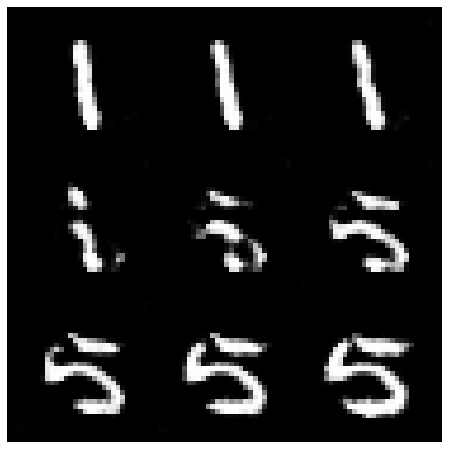

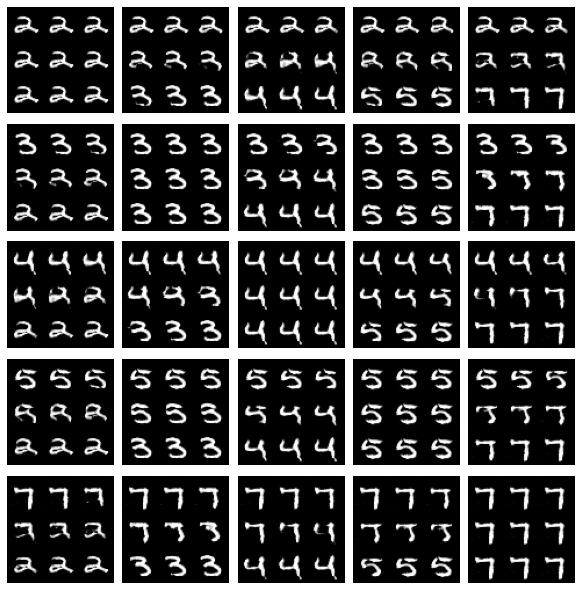

In [ ]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = torch.randn(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = F.one_hot(torch.Tensor([first_number]).long(), n_classes)
    second_label = F.one_hot(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 5 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class 
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Changing the Noise Vector
Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

In [ ]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = F.one_hot(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [torch.randn(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Saving the models' weights and Inferring on the test set

In [ ]:
curr_time = get_current_time()
curr_time

In [ ]:
path = os.path.join(os.getcwd(), curr_time)
os.makedirs(path, exist_ok=True)

print(path)

In [ ]:
save_model_info(path, model=disc, model_name="disc1.pt", optimizer=disc_opt, 
                optimizer_name="disc_optim1.pt")

In [ ]:
save_model_info(path, model=gen, model_name="gen1.pt", optimizer=gen_opt, 
                optimizer_name="gen_optim1.pt")

In [ ]:
loaded_gen1 = Generator(z_dim, img_dim).to(device)
loaded_gen_optim1 = optim.Adam(loaded_gen1.parameters(), lr=lr)
load_model_info(path, device, model=loaded_gen1, model_name="gen1.pt", 
                optimizer=loaded_gen_optim1, optimizer_name="gen_optim1.pt")